# Mean Shift
#### Basic Implementation
The following two functions find_peak and meanshift execute the basic mean shift algorithm.

In [65]:
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.io import loadmat
from scipy.spatial.distance import cdist
from sklearn.datasets import *
from IPython.core.display import clear_output
%matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 12

##### Load  and visualize sample data
The matrix is loaded into a numpy array of dimensions (2000, 3)

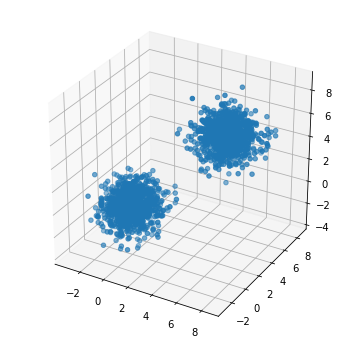

In [66]:
SAMPLE_DATA = loadmat("pts.mat")['data']
if True:  # Set to true to show the data
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(SAMPLE_DATA[0], SAMPLE_DATA[1], SAMPLE_DATA[2])

##### Utility functions


In [67]:
def dist(p1, p2):
    """ Returns the euclidian distance between p1 and p2."""
    return np.sqrt(np.sum(p1-p2)**2)
    

def get_neighbours(data, point, r):
    """
    :data: The n-dimensional dataset containing p points
    :point: The data point for which the density peak will be computed
    :r: The distance at which points are considered neighbours
    :return: A list of points with a euclidian distance < r.
    """
    ret = []
    if len(data) == 0 or len(data[0]) != 3 or point == None or r < 0:
        return []
    for i, d in enumerate(cdist(np.array([point]), data)[0]):
        if d < r:
            ret.append(data[i])
    return np.array(ret)


def log_progress(sequence, every=None, size=None, name='Items'):
    """Taken from https://github.com/alexanderkuk/log-progress"""
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [68]:
def find_peak(data, point, r):
    """
    :data: The n-dimensional dataset containing p points
    :point: The data point for which the density peak will be computed
    :r: The search windows radius
    :return: The found peak.
    """
    neighbours = get_neighbours(data, point, r)
    peak = neighbours.mean(axis=0)
    return peak

def meanshift(data, r):
    """
    Calls find_peak for every point in data. 
    Similar peaks are merged after each call, if their distance is smaller than r/2.
    :data: The n-dimensional dataset containing p points
    :r: The search windows radius
    :return: A list of peaks and a list of points, annotated with the index of their peak.
    """
    peaks = []
    annotated = {
        "points": [],
        "peaks": []
    }
    data_transposed = data.transpose()
    for idx, point in log_progress(enumerate(data_transposed), 1, len(data_transposed)):
        # calculate peaks until convergence
        old_peak = None
        while True:
            point = point if old_peak is None else old_peak
            peak = find_peak(data_transposed, point, r)
            if old_peak is None:
                old_peak = peak
            else:
                # match peak to possible neighbours
                neighbours = get_neighbours(np.array(peaks), peak, r/2.)
                if len(neighbours) > 1:
                    peak = neighbours[0]
                    break
                if dist(peak, old_peak) <= 0.01:  # converged
                    peaks.append(peak)
                    break
                else:
                    old_peak = peak
        annotated["points"].append(point)
        annotated["peaks"].append(np.where(peaks==peak)[0][0])
    annotated["points"] = np.array(annotated["points"])
    annotated["points"] = annotated["points"].transpose()
    annotated["peaks"] = np.array(annotated["peaks"], dtype=np.float32)
    return peaks, annotated

##### Execute the meanshift function
Visualize the results

/home/ric/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


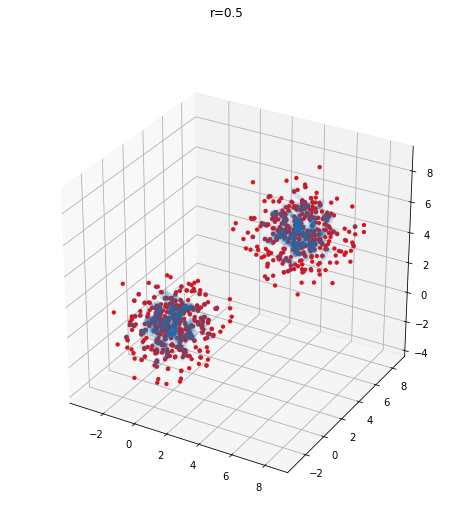

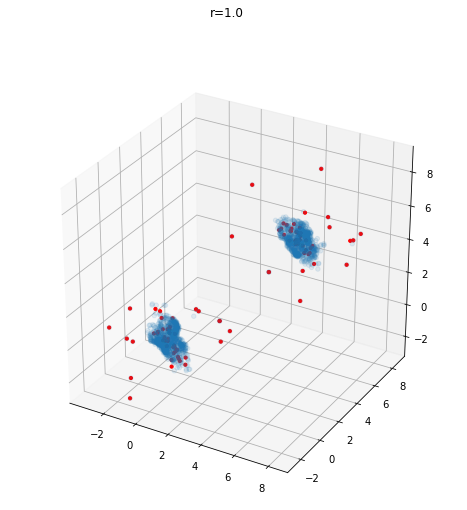

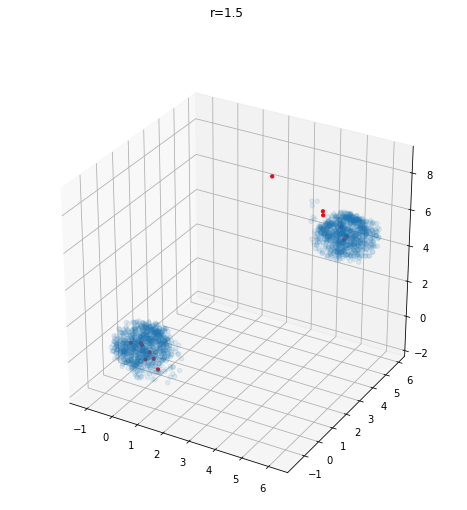

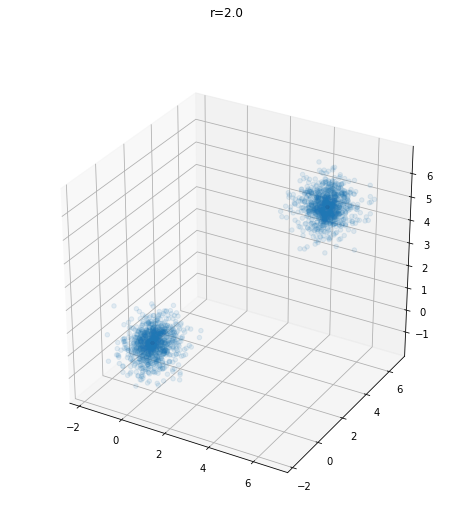

In [70]:
for r in range(5, 25, 5):
    peaks, annotated = meanshift(SAMPLE_DATA, r/10.)
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle("r={}".format(r/10.))
    ax = fig.add_subplot(111, projection="3d")
    x, y, z = zip(*peaks)
    ax.scatter(x, y, z, color="red", s=10, alpha=1)
    ax.scatter(annotated["points"][0], annotated["points"][1], annotated["points"][2], alpha=0.1)